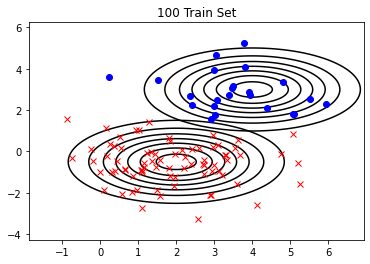

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
from scipy.stats import multivariate_normal


Settings = {}
Settings["mean1"] = [2.0, -0.5]
Settings["mean2"] = [4.0, 3.0]
Settings["sigma"] = [[2.0, 0.0], [0.0, 1.0]]
Settings["phi"]   = 0.3
Settings["train_cnt"] = 100
Settings["test_cnt"]  = 100
Settings["contour"]   = True

rd.seed(0)

def shuffle_in_unison(a, b):
    assert a.shape[0] == b.shape[0]
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = rd.permutation(a.shape[0])
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def sort_in_unison(a, b):
    assert a.shape[0] == b.shape[0]
    sorted_a = np.empty(a.shape, dtype=a.dtype)
    sorted_b = np.empty(b.shape, dtype=b.dtype)
    sorting_index = np.argsort(b, axis=0)
    for new_index, old_index in enumerate(sorting_index):
        sorted_a[new_index] = a[old_index]
        sorted_b[new_index] = b[old_index]
    return sorted_a, sorted_b

def data_generation(mean1, mean2, sigma, phi, train_cnt, test_cnt):
    y_train = rd.binomial(1, phi, train_cnt)
    y_train = np.sort(y_train)
    y_test  = rd.binomial(1, phi, test_cnt)
    y_test  = np.sort(y_test)
    
    x1_train = rd.multivariate_normal(mean1, sigma, train_cnt-np.sum(y_train))
    x2_train = rd.multivariate_normal(mean2, sigma, np.sum(y_train))
    x_train  = np.concatenate((x1_train, x2_train), axis=0)
    
    x1_test = rd.multivariate_normal(mean1, sigma, test_cnt-np.sum(y_test))
    x2_test = rd.multivariate_normal(mean2, sigma, np.sum(y_test))
    x_test  = np.concatenate((x1_test, x2_test), axis=0)
    
    x_train, y_train = shuffle_in_unison(x_train, y_train)
    x_test,  y_test  = shuffle_in_unison(x_test,  y_test)
    return x_train, y_train, x_test, y_test

def plot_data(x, y, mean1, mean2, sigma, title="", theta=np.empty(10), contour=False):
    x, y = sort_in_unison(x, y)
    x = x.T
    x1_cnt = y.shape[0] - np.sum(y)
    plt.figure
    if (title != ""):
        plt.title(title)
    if (theta.shape[0] == 2):
        x1_temp = np.arange(-1.0, 7.0, 0.01)
        x2_temp = (-theta[0] * x1_temp) / theta[1]
        plt.plot(x1_temp, x2_temp, 'black')
    elif (theta.shape[0] == 3):
        x1_temp = np.arange(np.min(x[0])-1, np.max(x[0])+1, 0.01)
        x2_temp = (-theta[1] * x1_temp - theta[0]) / theta[2]
        plt.plot(x1_temp, x2_temp, 'black')
    if (contour):
        cont_x, cont_y = np.mgrid[np.min(x[0])-1 : np.max(x[0])+1 : 0.01, np.min(x[1])-1 : np.max(x[1])+1 : 0.01]
        pos  = np.dstack((cont_x, cont_y))
        cont1 = multivariate_normal(mean1, sigma)
        cont2 = multivariate_normal(mean2, sigma)
        plt.contour(cont_x, cont_y, cont1.pdf(pos), colors='black')
        plt.contour(cont_x, cont_y, cont2.pdf(pos), colors='black')
    plt.plot(x[0,:x1_cnt], x[1,:x1_cnt], 'rx')
    plt.plot(x[0,x1_cnt:], x[1,x1_cnt:], 'bo')
    if (title != ""):
        plt.savefig(title.replace("\n", " "))
    plt.show()
    return

x_train, y_train, x_test, y_test = data_generation(mean1=Settings["mean1"], mean2=Settings["mean2"],\
                                         sigma=Settings["sigma"], phi=Settings["phi"],\
                                         train_cnt=Settings["train_cnt"], test_cnt=Settings["test_cnt"])
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"],\
          title="{} Train Set".format(Settings["train_cnt"]), sigma=Settings["sigma"], contour=Settings["contour"])

[-0.77221863  2.12195818]
Logistic Regression Accuracy : 92.0


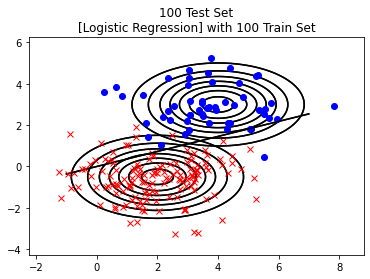

In [2]:
class LinearModel(object):
    """Base class for linear models."""
    
    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.
        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.
        Args:
            x: Inputs of shape (m, n).
        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')
        
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver."""

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.
        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # Init theta
        m, n = x.shape
        self.theta = np.zeros(n)

        # Newton's method
        while True:
            # Save old theta
            theta_old = np.copy(self.theta)
            
            # Compute Hessian Matrix
            h_x = 1 / (1 + np.exp(-x.dot(self.theta)))
            H = (x.T * h_x * (1 - h_x)).dot(x) / m
            gradient_J_theta = x.T.dot(h_x - y) / m

            # Updata theta
            self.theta -= np.linalg.inv(H).dot(gradient_J_theta)

            # End training
            if np.linalg.norm(self.theta-theta_old, ord=1) < self.eps:
                break
        return

    def predict(self, x):
        """Make a prediction given new inputs x.
        Args:
            x: Inputs of shape (m, n).
        Returns:
            Outputs of shape (m,).
        """
        return 1 / (1 + np.exp(-x.dot(self.theta)))

# Train logistic regression
model = LogisticRegression(eps=1e-5)
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Train Set\n[Logistic Regression]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])

def test_model(x, y, cnt, model, msg):
    y_pred = model.predict(x_test)
    y_pred = (y_pred >= 0.5)
    accuracy = (cnt - np.sum(np.logical_xor(y, y_pred))) * 100 / cnt
    print("{} Accuracy : {}".format(msg, accuracy))
    return

test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="Logistic Regression")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Test Set\n[Logistic Regression] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])

[-9.19489064  1.26393042  3.93645103]
GDA Accuracy : 96.0


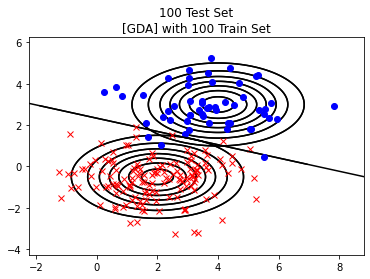

In [3]:
class GDA(LinearModel):
    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.
        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        Returns:
            theta: GDA model parameters.
        """
        # Init theta
        m, n = x.shape
        self.theta = np.zeros(n+1)

        # Compute phi, mu_0, mu_1, sigma
        y_1 = sum(y == 1)
        phi = y_1 / m
        mu_0 = np.sum(x[y == 0], axis=0) / (m - y_1)
        mu_1 = np.sum(x[y == 1], axis=0) / y_1
        sigma = ((x[y == 0] - mu_0).T.dot(x[y == 0] - mu_0) + (x[y == 1] - mu_1).T.dot(x[y == 1] - mu_1)) / m
        #sigma = (x[y == 1] - mu_1).T.dot(x[y == 1] - mu_1) / m

        # Compute theta
        sigma_inv = np.linalg.inv(sigma)
        self.theta[0] = 0.5 * (mu_0 + mu_1).dot(sigma_inv).dot(mu_0 - mu_1) - np.log((1 - phi) / phi)
        self.theta[1:] = sigma_inv.dot(mu_1 - mu_0)
        #self.theta[0] = np.log((1 - phi) / phi) - ((mu_0 ** 2 + mu_1 ** 2) / (2 * sigma))
        #self.theta[1] = (mu_0 - mu_1) / sigma
        
        # Return theta
        return self.theta

    def predict(self, x):
        """Make a prediction given new inputs x.
        Args:
            x: Inputs of shape (m, n).
        Returns:
            Outputs of shape (m,).
        """
        return 1 / (1 + np.exp(-(self.theta[0] + self.theta[1] * x[:,0] + self.theta[2] * x[:,1])))
# Train GDA
model = GDA()
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Train Set\n[GDA]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])
test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="GDA")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Test Set\n[GDA] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])

[-1.65891177  6.06922003]
Logistic Regression Accuracy : 91.0
[-4.8890384   0.12500101  3.65288844]
GDA Accuracy : 96.0


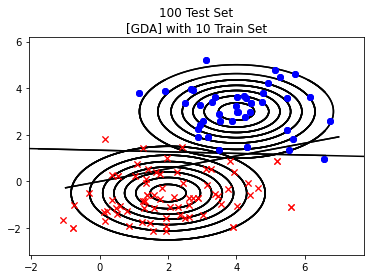

In [4]:
Settings["train_cnt"] = 10
x_train, y_train, x_test, y_test = data_generation(mean1=Settings["mean1"], mean2=Settings["mean2"],\
                                         sigma=Settings["sigma"], phi=Settings["phi"],\
                                         train_cnt=Settings["train_cnt"], test_cnt=Settings["test_cnt"])
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"],\
          title="{} Train Set".format(Settings["train_cnt"]), sigma=Settings["sigma"], contour=Settings["contour"])

# Train logistic regression
model = LogisticRegression(eps=1e-5)
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Train Set\n[Logistic Regression]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])
test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="Logistic Regression")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Test Set\n[Logistic Regression] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])

# Train GDA
model = GDA()
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Train Set\n[GDA]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])
test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="GDA")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Test Set\n[GDA] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])

[-0.79603628  2.35620708]
Logistic Regression Accuracy : 85.0
[-8.5527222   1.05506641  3.74232332]
GDA Accuracy : 98.0


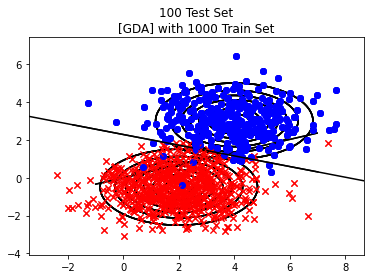

In [5]:
Settings["train_cnt"] = 1000
x_train, y_train, x_test, y_test = data_generation(mean1=Settings["mean1"], mean2=Settings["mean2"],\
                                         sigma=Settings["sigma"], phi=Settings["phi"],\
                                         train_cnt=Settings["train_cnt"], test_cnt=Settings["test_cnt"])
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"],\
          title="{} Train Set".format(Settings["train_cnt"]), sigma=Settings["sigma"], contour=Settings["contour"])

# Train logistic regression
model = LogisticRegression(eps=1e-5)
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Train Set\n[Logistic Regression]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])
test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="Logistic Regression")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title = "{} Test Set\n[Logistic Regression] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])

# Train GDA
model = GDA()
model.fit(x_train, y_train)
print(model.theta)
plot_data(x=x_train, y=y_train, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Train Set\n[GDA]".format(Settings["train_cnt"]), theta=model.theta, contour=Settings["contour"])
test_model(x=x_test, y=y_test, model=model, cnt=Settings["test_cnt"], msg="GDA")
plot_data(x=x_test, y=y_test, mean1=Settings["mean1"], mean2=Settings["mean2"], sigma=Settings["sigma"],\
          title="{} Test Set\n[GDA] with {} Train Set".format(Settings["test_cnt"], Settings["train_cnt"]),\
          theta=model.theta, contour=Settings["contour"])